In [757]:
## Importing Libraries ##
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os 

## Import model
# from baselines.wide_resnet import WideResNet
# from rank1_wide_resnet import Rank1Bayesian_WideResNet

### Initial (potential) changing of directory

In [616]:
original_directory = os.getcwd()
print(f"The original directory is {original_directory}")

The original directory is /Users/jonathansimonsen/Desktop/DTU/Bachelor-project/Project_Code


**If and only if doing BNN experiment, run this code block:**

In [620]:
## Set working directory to BNN
import os 
os.chdir('BNN')  # Change to the subdirectory where your scripts are located
print("Current Working Directory: ", os.getcwd())

Current Working Directory:  /Users/jonathansimonsen/Desktop/DTU/Bachelor-project/Project_Code/BNN


**To un-do the above, run this**

In [618]:
os.chdir(original_directory)
print(f"The working directory is now again {original_directory}")

The working directory is now again /Users/jonathansimonsen/Desktop/DTU/Bachelor-project/Project_Code


**RUN THIS BEFORE RUNNING SUBSEQUENT CODE TO ENSURE CORRECT DIRECTORY**

In [622]:
print(f"THE WORKING DIRECTORY IS {os.getcwd()}")

THE WORKING DIRECTORY IS /Users/jonathansimonsen/Desktop/DTU/Bachelor-project/Project_Code/BNN


## Import models and load saved parameters

In [758]:
# Import model architecture
framework = "BNN"
# framework = "Deterministic"

if framework == "BNN":
    from BNN.rank1_wide_resnet import Rank1Bayesian_WideResNet
    print("Using BNN framework")

    model = Rank1Bayesian_WideResNet(depth=28, widen_factor=10, num_classes=10, ensemble_size=2)
    saved_model_bnn_path = 'r1BNN_seed-321_2-components.pth'
    model.load_state_dict(torch.load(saved_model_bnn_path, map_location=torch.device('cpu')))

elif framework == "Deterministic":
    from baselines.wide_resnet import WideResNet
    print("Using Deterministic framework")

    model = WideResNet(depth=28, widen_factor=10, num_classes=10)
    saved_model_det_path = 'deterministic_WR_model.pth'
    model.load_state_dict(torch.load(saved_model_det_path, map_location=torch.device('cpu')))

# Check if MPS is available
if torch.backends.mps.is_available():
    mps_device = torch.device('mps')
    model.to(mps_device)
    print("MPS device available, using MPS.")
else:
    print("MPS device not available, using CPU instead.")

Using BNN framework
MPS device available, using MPS.


## Find and extract two images to be used in experiment

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


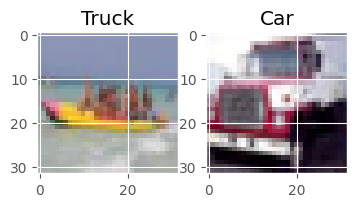

In [759]:
# Define a transform to normalize the data
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
data_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

# Load the data 
testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=False, transform=data_transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=True, num_workers=2)

# Define the classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to show an image
def imshow(img):
    # Undo the normalization for display purposes
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.show()

# Function to get a single image from a specific class
def get_image_from_class(loader, class_name):
    for idx, (images, labels) in enumerate(loader):
        if classes[labels[0]] == class_name:
            return images[0], labels[0], idx

# Get an image from the truck category
truck_img, truck_label, truck_idx = get_image_from_class(testloader, 'ship')
car_img, car_label, car_idx = get_image_from_class(testloader, 'truck')
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.title('Truck')
imshow(truck_img)
plt.subplot(1,2,2)
plt.title('Car')
imshow(car_img)
plt.show()


## Create interpolated images from these images 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


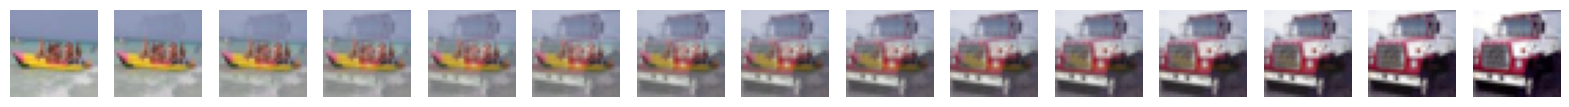

In [760]:
# Function to interpolate between two images
def interpolate_images(img1, img2, steps=10):
    interpolated_images = []
    for alpha in np.linspace(0, 1, steps):
        interpolated_image = (1 - alpha) * img1 + alpha * img2
        interpolated_images.append(interpolated_image)
    return interpolated_images

# Generate interpolated images (first image is original img1, last image is original img2, rest inbetween are interpolated)
num_images = 15
interpolated_images = interpolate_images(truck_img, car_img, steps=num_images)

plt.figure(figsize=(20, 5))
for i, img in enumerate(interpolated_images):
    plt.subplot(1, num_images, i+1)
    imshow(img)
    plt.axis('off')
plt.show()

## Perform forward passes and save logits and softmax values

In [762]:
def collect_predictions(model, images, num_passes=1):
    model.eval()

    all_softmax_inputs = []
    all_softmax_outputs = []

    for img in images:
        softmax_inputs = []
        softmax_outputs = []
        img = img.unsqueeze(0).to(mps_device)  # Add batch dimension and move to device

        with torch.no_grad():
            for _ in range(num_passes):
                output = model(img)
                print(f"Model output shape: {output.shape}")
                softmax_input = output  # Logits before softmax
                softmax_output = torch.nn.functional.softmax(output, dim=1)  # Softmax probabilities
                print(softmax_output.shape)

                softmax_output = softmax_output.mean(dim=0)
                print(softmax_output.shape)
                
                softmax_input = softmax_input.view(-1)
                softmax_output = softmax_output.view(-1)
                print(softmax_output.shape)
                softmax_inputs.append(softmax_input.cpu().numpy())
                softmax_outputs.append(softmax_output.cpu().numpy())

        all_softmax_inputs.append(np.array(softmax_inputs))
        all_softmax_outputs.append(np.array(softmax_outputs))

    return np.array(all_softmax_inputs), np.array(all_softmax_outputs)

## Plots

In [763]:
num_forward_passes = 20
softmax_inputs, softmax_outputs = collect_predictions(model, interpolated_images, num_passes=num_forward_passes)


truck_softmax_input = softmax_inputs[:, :, truck_label]
car_softmax_input = softmax_inputs[:, :, car_label]

truck_softmax_output = softmax_outputs[:, :, truck_label]
car_softmax_output = softmax_outputs[:, :, car_label]
mean_truck_softmax_output = np.mean(truck_softmax_output, axis=1)
mean_car_softmax_output = np.mean(car_softmax_output, axis=1)
print(truck_softmax_output.shape)
print(mean_truck_softmax_output.shape)




Model output shape: torch.Size([2, 10])
torch.Size([2, 10])
torch.Size([10])
torch.Size([10])
Model output shape: torch.Size([2, 10])
torch.Size([2, 10])
torch.Size([10])
torch.Size([10])
Model output shape: torch.Size([2, 10])
torch.Size([2, 10])
torch.Size([10])
torch.Size([10])
Model output shape: torch.Size([2, 10])
torch.Size([2, 10])
torch.Size([10])
torch.Size([10])
Model output shape: torch.Size([2, 10])
torch.Size([2, 10])
torch.Size([10])
torch.Size([10])
Model output shape: torch.Size([2, 10])
torch.Size([2, 10])
torch.Size([10])
torch.Size([10])
Model output shape: torch.Size([2, 10])
torch.Size([2, 10])
torch.Size([10])
torch.Size([10])
Model output shape: torch.Size([2, 10])
torch.Size([2, 10])
torch.Size([10])
torch.Size([10])
Model output shape: torch.Size([2, 10])
torch.Size([2, 10])
torch.Size([10])
torch.Size([10])
Model output shape: torch.Size([2, 10])
torch.Size([2, 10])
torch.Size([10])
torch.Size([10])
Model output shape: torch.Size([2, 10])
torch.Size([2, 10])


KeyboardInterrupt: 

### Softmax output plots

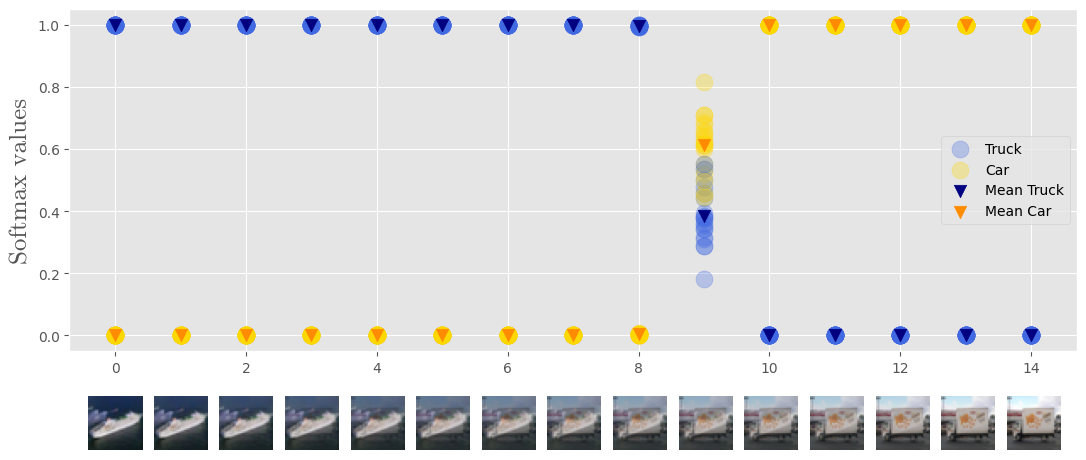

In [749]:
# Create the plot
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(13, 4.5))

def denormalize(image):
    image = image.numpy().transpose((1, 2, 0))  # Convert to HWC
    image = np.array([0.2023, 0.1994, 0.2010]) * image + np.array([0.4914, 0.4822, 0.4465])  # De-normalize
    image = np.clip(image, 0, 1)  # Clip to [0, 1] range
    return image

images = [denormalize(image) for image in interpolated_images]


for i in range(num_forward_passes):
    ax.scatter(range(num_images), truck_softmax_output[:, i], marker='o', c='royalblue', label='Truck' if i == 0 else None, alpha=0.3, s=150)
    ax.scatter(range(num_images), car_softmax_output[:, i], marker='o', c='gold', label='Car' if i == 0 else None, alpha=0.3, s=150)

ax.scatter(range(num_images), mean_truck_softmax_output, marker='v', c='navy', label='Mean Truck', s=80)
ax.scatter(range(num_images), mean_car_softmax_output, marker='v', c='darkorange', label='Mean Car', s=80)

# Label the axes
# ax.set_xlabel('Image Index')
ax.set_ylabel('Softmax values', fontname='cmr10', fontsize=18, rotation=90)
# ax.set_title('Values from Forward Passes for Each Image')
ax.legend()

# Add a legend
plt.legend()

# Add images below the x-axis
for i in range(num_images):
    # Create an inset axis for each image
    inset_ax = fig.add_axes([0.1 + i * 0.0505, -0.1, 0.12, 0.12])  # Adjust the position and size
    inset_ax.imshow(images[i])
    inset_ax.axis('off')  # Turn off axis for images

# Adjust the main plot to make space for the images
plt.subplots_adjust(bottom=0.12)

# Show the plot
plt.show()



### Logits (softmax input) plots

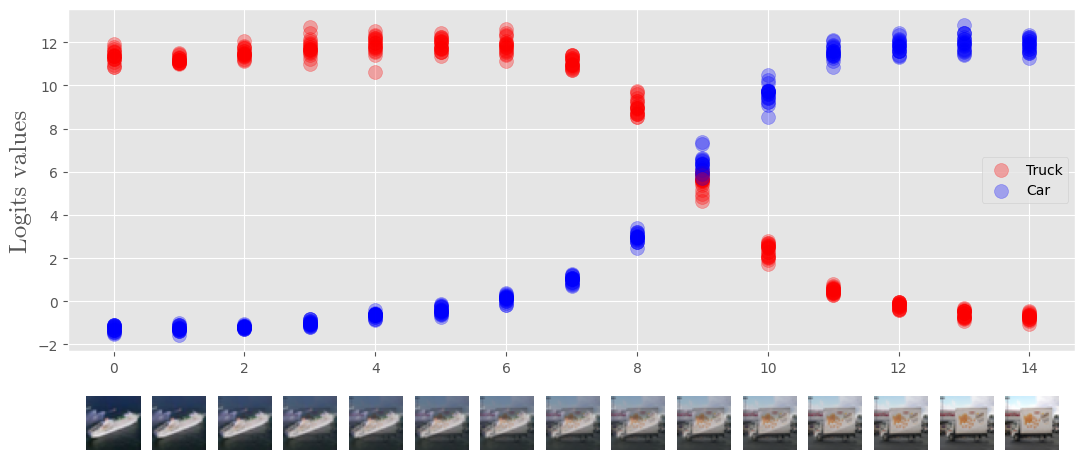

In [750]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(13, 4.5))

for i in range(num_forward_passes):
    ax.scatter(range(num_images), truck_softmax_input[:, i], marker='o', c='r', label='Truck' if i == 0 else None, alpha=0.3, s=100)
    ax.scatter(range(num_images), car_softmax_input[:, i], marker='o', c='b', label='Car' if i == 0 else None, alpha=0.3, s=100)

# Label the axes
# ax.set_xlabel('Image Index')
ax.set_ylabel('Logits values', fontname='cmr10', fontsize=18, rotation=90)
# ax.set_title('Values from Forward Passes for Each Image')
ax.legend()

# Add a legend
plt.legend()

# Add images below the x-axis
for i in range(num_images):
    # Create an inset axis for each image
    inset_ax = fig.add_axes([0.1 + i * 0.0505, -0.1, 0.12, 0.12])  # Adjust the position and size
    inset_ax.imshow(images[i])
    inset_ax.axis('off')  # Turn off axis for images

# Adjust the main plot to make space for the images
plt.subplots_adjust(bottom=0.12)

# Show the plot
plt.show()

In [ ]:
def collect_predictions(model, images, num_passes=1):
    model.eval()

    all_softmax_inputs = []
    all_softmax_outputs = []

    for img in images:
        softmax_inputs = []
        softmax_outputs = []
        img = img.unsqueeze(0).to(mps_device)  # Add batch dimension and move to device

        with torch.no_grad():
            for _ in range(num_passes):
                output = model(img)
                softmax_input = output  # Logits before softmax
                softmax_output = torch.nn.functional.softmax(output, dim=1)  # Softmax probabilities
                print(softmax_output.shape)
                
                softmax_input = softmax_input.view(-1)
                softmax_output = softmax_output.view(-1)
                print(softmax_output.shape)
                softmax_inputs.append(softmax_input.cpu().numpy())
                softmax_outputs.append(softmax_output.cpu().numpy())

        all_softmax_inputs.append(np.array(softmax_inputs))
        all_softmax_outputs.append(np.array(softmax_outputs))

    return np.array(all_softmax_inputs), np.array(all_softmax_outputs)

In [752]:
np.log(2*3/4)

0.4054651081081644

In [754]:
np.log(2) + np.log(3) - np.log(4)

0.4054651081081644